Kernel Density Estimates 
=================

Because the SNE methods generate many thousands (typically tens of thousands) of orientation estimates, traditional stereonet techniques for structural analysis are no longer applicable, and even simple tasks like plotting stereonets can become difficult. The following demonstrates utility functions for generating Kernel Density Estimates (KDEs) that makes probabalistic data analysis and visualisation achievable with such large sample numbers.

In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplstereonet
import numpy as np

sys.path.append("../../") #libs directory
from pycompass.SNE import pdf

%matplotlib inline

KDE on circular data
=====

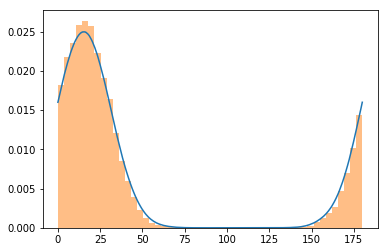

In [38]:
#calculate random strike dataset
strike = np.random.normal(15,15,20000)
for i in range(len(strike)):
    while strike[i] < 0:
        strike[i] += 180
        
#do kde with 5 degree bandwidth
kde = pdf.circularKDE( strike, 5 )

#plot
plt.plot(np.linspace(0,180,len(kde)),kde)
plt.hist(strike,normed=True,bins=50,alpha=0.5)
plt.show()

And the above as a rose diagram:

In [39]:
def plotRoseHist(strikes, **kwds):
    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, normed=True)
    number_of_strikes[0] += number_of_strikes[-1]

    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])

    
    if "ax" in kwds:
        ax = kwds.get("ax")
        fig = ax.figure
    else:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='polar')
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color='orange', alpha=0.4, edgecolor='k')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.get_yaxis().set_visible(False)
    return fig,ax
    
def plotRoseKDE(strikesKDE, **kwds):
    
    _theta = np.linspace(0,360,len(strikesKDE)*2)
    _dens = np.append(strikesKDE,strikesKDE)
    
    if "ax" in kwds:
        ax = kwds.get("ax")
        fig = ax.figure
    else:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='polar')
        
    ax.plot( np.deg2rad(_theta),_dens, color='k')
    ax.fill( np.deg2rad(_theta),_dens, color='gray',alpha=0.25)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.get_yaxis().set_visible(False)
    return fig, ax


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


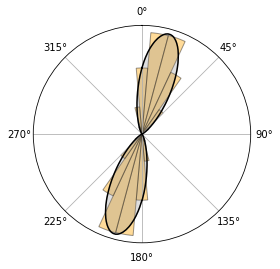

In [40]:
fig,ax = plotRoseHist(strike)
plotRoseKDE(kde,ax=ax)
fig.show()

KDE on spherical data
===============

In [2]:
#generate a fake dataset
pop1 = np.array([np.random.normal(315,10,200),np.random.normal(50,1,200)]) #trend = 045+-10 degrees, plunge = 60+-10 degrees
pop2 = np.array([np.random.normal(45,5,1000),np.random.normal(45,45,1000)]) #trend = 270+-10 degrees, plunge = 0+-30 degrees
data = np.array([np.append(pop1[0],pop2[0]),np.append(pop1[1],pop2[1])])

In [3]:
#evaluate kde on grid
res = 250 #grid resolution
bw = 5 #bandwidth of kde (in degrees)
grid = pdf.grid(res)
kde = pdf.sphericalKDE(grid,data,bw,degrees=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


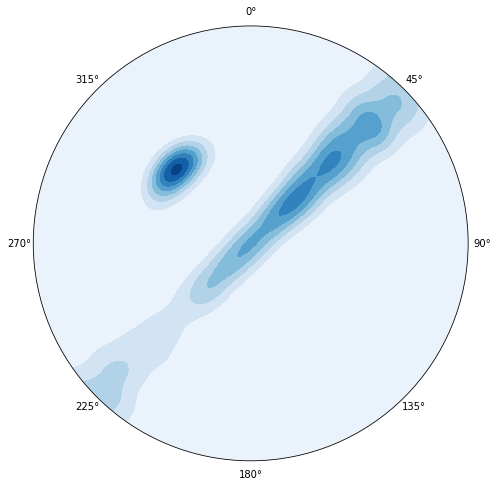

In [5]:
#reshape kde into a 2D grid
res = int(np.sqrt(grid.shape[1]))
assert res == np.sqrt(grid.shape[1]), "Error plotting KDE - supplied grid must be square."
kde2D = np.reshape(kde,(res,res)).T

#build meshgrid of plotting coordinates (in lat,lon)
bound = np.pi / 2
X,Y = np.meshgrid(np.linspace(-bound,bound,res), np.linspace(-bound,bound,res)) #rectangular plot of polar data

#plot
figsize = (8,8)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(111, projection='stereonet')
#cs = ax1.pcolormesh(X,Y,kde2D,**kwds)
cs = ax1.contourf(X,Y,kde2D,cmap="R")

fig.show()

Pure python angular KDE example
=============

Shows how that above are implemented using the angular differences between vectors.

<function matplotlib.pyplot.show>

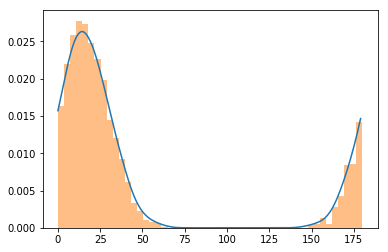

In [9]:
import scipy.stats

X  = np.linspace(0,np.pi,180,endpoint=False)
kernel = scipy.stats.norm.pdf(np.linspace(0,np.pi/2,90),0,np.deg2rad(5))
density = np.zeros(180)

#calculate strike angle (in radians) of each SNE
strike = np.deg2rad(np.random.normal(15,15,2000))
#map to domain 0 - pi
for i in range(len(strike)):
    while strike[i] < 0:
        strike[i] += np.pi


#accumulate probability density into each bin of the kernel
for i,_x in enumerate(X):
    b = np.array([np.sin(_x),np.cos(_x)]) #direction vector of this bin
    for _s in strike:
        #calculate angle between this SNE and the bin
        _a =  np.arccos( np.abs( np.dot(b,np.array([np.sin(_s),np.cos(_s)])) ) )

        #accumulate probability density onto the kernel
        assert i < 180, "Error - invalid i = %d" % i
        assert int(np.rad2deg(_a)) < 90, "Error - invalid _a = %d" % (int(np.rad2deg(_a)))
        density[i] += kernel[int(np.rad2deg(_a))]

density /= np.trapz(density,np.rad2deg(X)) #normalize so area is 1. Note that we can't just divide by the number of samples here as the 
                               #numerical approximations we make mean the area becomes larger than one (~1.1)

plt.plot(np.rad2deg(X),density)
plt.hist(np.rad2deg(strike),normed=True,bins=50,alpha=0.5)
plt.show